In [1]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image, ImageOps
import torch
import os
import glob

import matplotlib.pyplot as plt

GPU = "cuda" if torch.cuda.is_available() else "cpu"
CPU = "cpu"

# 모델 로딩
model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14").to(GPU)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")

c:\Users\frien\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [2]:
import time

# Memoize file's last modified timestamp to prevent re-calculating same file
image_cache = {}

image_dir = "Camera"  # 이미지 폴더
image_paths = glob.glob(f"{image_dir}/*.jpg")
print(len(image_paths), "files")

437 files


In [9]:
# Case 1 : No batch
# Load - Preprocess - Calc - Load - ...

# 이미지 임베딩 저장
image_embeddings = []
image_names = []

USE_CACHE = False

load_time = 0
calc_time = 0

with torch.no_grad():
    for idx, img_path in enumerate(image_paths):
        print(f"Processing {idx+1}/{len(image_paths)}: {img_path}")
        image_last_modified = os.path.getmtime(img_path)
        if USE_CACHE and image_cache.get(img_path) and image_cache[img_path][0] == image_last_modified:
            image_features = image_cache[img_path]
        else:
            start_time = time.time()
            image = Image.open(img_path)
            ImageOps.exif_transpose(image, in_place=True)
            load_time += time.time() - start_time
            start_time = time.time()
            inputs = processor(images=image, return_tensors="pt").to(GPU)
            image_features = model.get_image_features(**inputs)
            calc_time += time.time() - start_time
            if USE_CACHE:
                image_cache[img_path] = (image_last_modified, image_features)
        image_embeddings.append(image_features)
        image_names.append(os.path.basename(img_path))

    start_time = time.time()
    image_embeddings = torch.cat(image_embeddings, dim=0)  # [num_images, 768]
    image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
    calc_time += time.time() - start_time

print(f"Load : {load_time:.6f} sec")
print(f"Calc : {calc_time:.6f} sec")

Processing 1/437: Camera\20231027_141831.jpg
Processing 2/437: Camera\20231030_230214.jpg
Processing 3/437: Camera\20231101_150420.jpg
Processing 4/437: Camera\20231101_172043.jpg
Processing 5/437: Camera\20231102_150333.jpg
Processing 6/437: Camera\20231103_193238.jpg
Processing 7/437: Camera\20231106_115256.jpg
Processing 8/437: Camera\20231107_174651.jpg
Processing 9/437: Camera\20231107_214057.jpg
Processing 10/437: Camera\20231113_142253.jpg
Processing 11/437: Camera\20231113_144247.jpg
Processing 12/437: Camera\20231113_144435.jpg
Processing 13/437: Camera\20231113_215252.jpg
Processing 14/437: Camera\20231115_145610.jpg
Processing 15/437: Camera\20231115_150128.jpg
Processing 16/437: Camera\20231115_150344.jpg
Processing 17/437: Camera\20231115_150754.jpg
Processing 18/437: Camera\20231115_213434.jpg
Processing 19/437: Camera\20231116_150734.jpg
Processing 20/437: Camera\20231116_150915.jpg
Processing 21/437: Camera\20231117_115106.jpg
Processing 22/437: Camera\20231117_115309.j

In [8]:
# Case 2 : N-size batch
# Load all images - Each batch Preprocess and calc

# 이미지 임베딩 저장
image_features_list = []
image_names = []

image_cached_embeddings = []
image_cached_names = []

USE_CACHE = False
BATCH_SIZE = 8

load_time = 0
calc_time = 0

with torch.no_grad():
    batch_iter = (len(image_paths)-1)//BATCH_SIZE+1
    start_idx = 0
    end_idx = BATCH_SIZE
    for batch in range(batch_iter):
        print(f"Processing batch {batch+1}/{batch_iter} ({start_idx+1} ~ {end_idx})")
        image_objects = []
        start_time = time.time()
        for idx in range(start_idx, end_idx):
            img_path = image_paths[idx]
            image_last_modified = os.path.getmtime(img_path)
            if USE_CACHE and image_cache.get(img_path) and image_cache[img_path][0] == image_last_modified:
                image_cached_embeddings.append(image_cache[img_path][1])
                image_cached_names.append(os.path.basename(img_path))
            else:
                image = Image.open(img_path)
                ImageOps.exif_transpose(image, in_place=True)
                image_objects.append(image)
                image_names.append(os.path.basename(img_path))
                if USE_CACHE:
                    image_cache[img_path] = (image_last_modified, None)
        load_time += time.time() - start_time
        start_time = time.time()
        inputs = processor(images=image_objects, return_tensors="pt").to(GPU)
        image_features = model.get_image_features(**inputs)
        image_features_list.append(image_features)
        calc_time += time.time() - start_time
        start_idx += BATCH_SIZE
        end_idx = min(end_idx + BATCH_SIZE, len(image_paths))

    start_time = time.time()
    image_embeddings = torch.cat(image_features_list)
    image_embeddings = image_embeddings / image_embeddings.norm(p=2, dim=-1, keepdim=True)
    calc_time += time.time() - start_time
    
    if USE_CACHE:
        image_embeddings = torch.cat([image_embeddings, torch.stack(image_cached_embeddings).to(GPU)])
        image_names.extend(image_cached_names)
        for idx, img_path in enumerate(image_paths):
            if image_cache[img_path][1] is None:
                image_cache[img_path] = (image_cache[img_path][0], image_embeddings[idx])

print(f"Load : {load_time:.6f} sec")
print(f"Calc : {calc_time:.6f} sec")

Processing batch 1/55 (1 ~ 8)
Processing batch 2/55 (9 ~ 16)
Processing batch 3/55 (17 ~ 24)
Processing batch 4/55 (25 ~ 32)
Processing batch 5/55 (33 ~ 40)
Processing batch 6/55 (41 ~ 48)
Processing batch 7/55 (49 ~ 56)
Processing batch 8/55 (57 ~ 64)
Processing batch 9/55 (65 ~ 72)
Processing batch 10/55 (73 ~ 80)
Processing batch 11/55 (81 ~ 88)
Processing batch 12/55 (89 ~ 96)
Processing batch 13/55 (97 ~ 104)
Processing batch 14/55 (105 ~ 112)
Processing batch 15/55 (113 ~ 120)
Processing batch 16/55 (121 ~ 128)
Processing batch 17/55 (129 ~ 136)
Processing batch 18/55 (137 ~ 144)
Processing batch 19/55 (145 ~ 152)
Processing batch 20/55 (153 ~ 160)
Processing batch 21/55 (161 ~ 168)
Processing batch 22/55 (169 ~ 176)
Processing batch 23/55 (177 ~ 184)
Processing batch 24/55 (185 ~ 192)
Processing batch 25/55 (193 ~ 200)
Processing batch 26/55 (201 ~ 208)
Processing batch 27/55 (209 ~ 216)
Processing batch 28/55 (217 ~ 224)
Processing batch 29/55 (225 ~ 232)
Processing batch 30/55

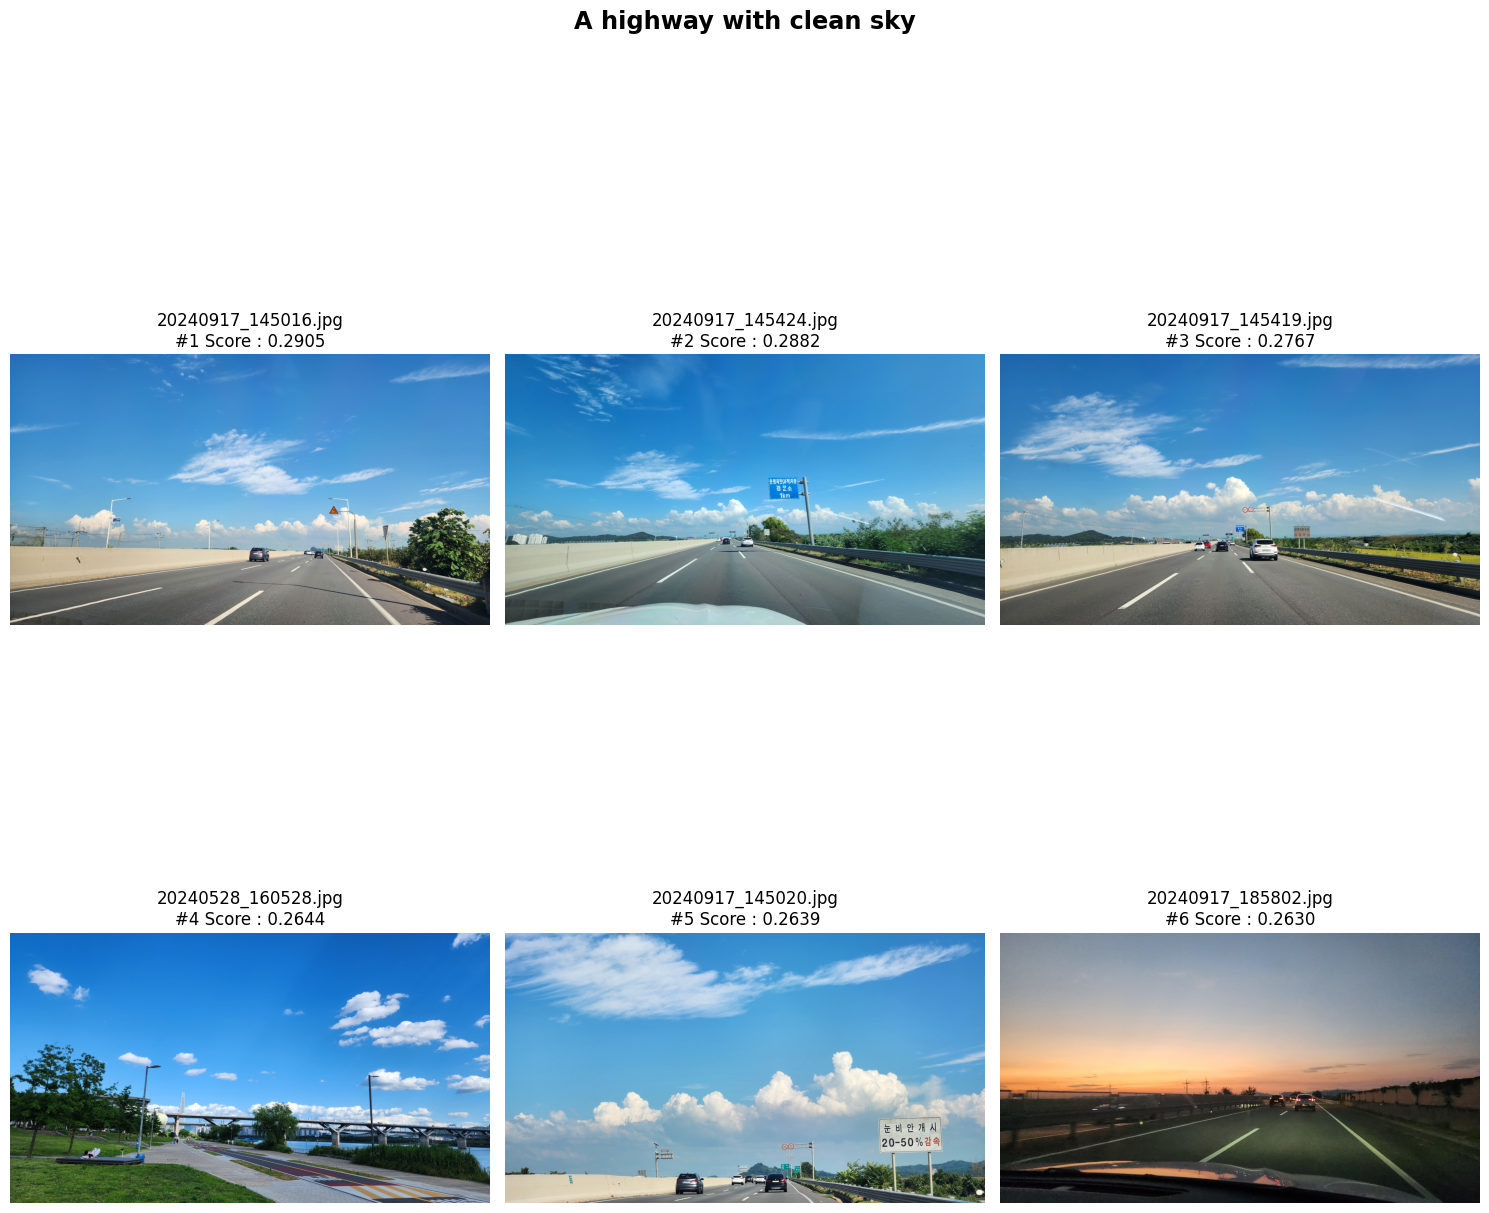

In [17]:
# 텍스트 검색 질의
query = "A highway with clean sky"

# 텍스트 임베딩
with torch.no_grad():
    inputs = processor(text=[query], return_tensors="pt", padding=True).to(GPU)
    text_features = model.get_text_features(**inputs)
    text_features = text_features / text_features.norm(p=2, dim=-1, keepdim=True)

    # 유사도 계산
    similarities = text_features @ image_embeddings.T  # [1, num_images]

similarities = similarities.to(device=CPU).reshape((-1,))
similarities_with_index = list(zip(similarities, range(similarities.numel())))
similarities_with_index.sort()

NROW, NCOL = 2, 3
fig, ax = plt.subplots(nrows=NROW, ncols=NCOL, figsize=[15, 15])
fig.suptitle(query, size='xx-large', weight='bold', y=1)
for i in range(1, NROW*NCOL+1):
    score, idx = similarities_with_index[-i]
    image_name = image_names[idx]
    image = Image.open(os.path.join(image_dir, image_name))
    ImageOps.exif_transpose(image, in_place=True)
    axi = ax[(i-1)//NCOL][(i-1)%NCOL]
    axi.imshow(image)
    axi.axis('off')
    axi.set_title(f"{image_name}\n#{i} Score : {score:.4f}")
fig.tight_layout()
plt.show()